In [1]:
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
from lib.models import *
import time 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

tf.compat.v1.enable_eager_execution()
 #seed 
seed = 1337
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
data_dir = "data/physionet/physionet.npz"
data_dim = 35
time_length = 48
num_classes = 2
batch_size = 64
data = np.load(data_dir)
x_train_full = data['x_train_full']
x_train_miss = data['x_train_miss']
m_train_miss = data['m_train_miss']
testing = False
if testing: 
    x_val_full = data['x_train_full']
    x_val_miss = data['x_train_miss']
    m_val_miss = data['m_train_miss']
    y_val = data['y_train']
    m_val_artificial = data["m_train_artificial"]
else:
    x_val_full = data["x_val_full"]  # full for artificial missings
    x_val_miss = data["x_val_miss"]
    m_val_miss = data["m_val_miss"]
    m_val_artificial = data["m_val_artificial"]
    y_val = data["y_val"]
tf_x_train_miss = tf.data.Dataset.from_tensor_slices((x_train_miss, m_train_miss))\
                                    .shuffle(len(x_train_miss)).batch(batch_size).repeat()
tf_x_val_miss = tf.data.Dataset.from_tensor_slices((x_val_miss, m_val_miss)).batch(batch_size).repeat()
tf_x_val_miss = tf.compat.v1.data.make_one_shot_iterator(tf_x_val_miss)

latent_dim = 35
encoder_sizes = [128, 128] 
decoder_sizes = [256,256]
encoder = DiagonalEncoder
decoder = GaussianDecoder
window_size = 24
beta = 0.2 #Factor to weigh the KL term (similar to beta-VAE)
M = 5 #Number of samples for ELBO estimation
K = 5 #Number of importance sampling weights

kerles = ['rbf', 'diffusion', 'matern', 'cauchy']
kernel = 'cauchy'
banded_covar = True
encoder = BandedJointEncoder if banded_covar else JointEncoder

exp_name = f"test_kernel_{kernel}_encoder_{encoder.__name__}_k_{K}_m{M}"
basedir = "experiments"
timestamp = datetime.now().strftime("%y%m%d")

full_exp_name = "{}_{}".format(timestamp, exp_name)
outdir = os.path.join(basedir, full_exp_name)
os.makedirs(outdir, exist_ok=True)

checkpoint_prefix = os.path.join(outdir, "ckpt")
print("Full exp name: ", full_exp_name)


data_type = "physionet"
sigma = 1.005
length_scale = 1.0 #Il contrôle l'influence de la distance entre les points sur leur corrélation.
kernel_scales = 1
model = GP_VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
    encoder_sizes=encoder_sizes, encoder=encoder,
    decoder_sizes=decoder_sizes, decoder=decoder,
    kernel=kernel, sigma=sigma,
    length_scale=length_scale, kernel_scales = kernel_scales,
    window_size=window_size,
    beta=beta, M=M, K=K, data_type=data_type)



# Fixation des hyperparamètres comme constantes
learning_rate = 1e-3
num_epochs = 40
batch_size = 64
print_interval = 0 # Interval for printing the loss and saving the model during training
num_steps = 0  # Number of training steps: If non-zero it overwrites num_epochs

# Vérifier la disponibilité du GPU
print("GPU support: ", tf.test.is_gpu_available())

# Initialisation de l'entraînement
print("Training...")
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()

# Initialisation de l'optimiseur
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

# Affichage des résumés des modèles
print("Encoder: ", model.encoder.net.summary())
print("Decoder: ", model.decoder.net.summary())

# Vérification du préprocesseur
saver = tf.compat.v1.train.Checkpoint(
    optimizer=optimizer,
    encoder=model.encoder.net,
    decoder=model.decoder.net,
    optimizer_step=tf.compat.v1.train.get_or_create_global_step()
)
summary_writer = tf.contrib.summary.create_file_writer(outdir, flush_millis=10000)

# Calcul du nombre total d'étapes d'entraînement
if num_steps == 0:
    num_steps = num_epochs * len(x_train_miss) // batch_size
else:
    num_steps = num_steps

# Ajustement de l'intervalle d'affichage
if print_interval == 0:
    print_interval = num_steps // num_epochs



W0115 15:34:05.031219 10164 deprecation.py:323] From c:\Users\Emobot\Desktop\repo git\GP-VAE\env\lib\site-packages\tensorflow_core\python\data\util\random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0115 15:34:05.231331 10164 module_wrapper.py:139] From c:\Users\Emobot\Desktop\repo git\GP-VAE\lib\models.py:292: The name tf.is_finite is deprecated. Please use tf.math.is_finite instead.

W0115 15:34:05.231331 10164 module_wrapper.py:139] From c:\Users\Emobot\Desktop\repo git\GP-VAE\lib\utils.py:20: The name tf.log is deprecated. Please use tf.math.log instead.

W0115 15:34:05.231331 10164 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorfl

Full exp name:  250115_test_kernel_cauchy_encoder_BandedJointEncoder_k_5_m5
GPU support:  False
Training...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  107648    
_________________________________________________________________
dense (Dense)                multiple                  16512     
_________________________________________________________________
dense_1 (Dense)              multiple                  13545     
Total params: 137,705
Trainable params: 137,705
Non-trainable params: 0
_________________________________________________________________
Encoder:  None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  9216      
_____________________________________

In [ ]:

gradient_clip = 1e4
losses_train = []
losses_val = []
t0 = time.time()
# Early stopping parameters
early_stopping_patience = 10  
best_val_loss = float("inf")  
patience_counter = 0          

with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
    for i, (x_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
        with tf.GradientTape() as tape:
            tape.watch(trainable_vars)
            loss = model.compute_loss(x_seq, m_mask=m_seq)
            losses_train.append(loss.numpy())
        
        grads = tape.gradient(loss, trainable_vars)
        grads = [np.nan_to_num(grad) for grad in grads]
        grads, global_norm = tf.clip_by_global_norm(grads, gradient_clip)
        optimizer.apply_gradients(zip(grads, trainable_vars),
                                global_step=tf.compat.v1.train.get_or_create_global_step())

        if i % print_interval == 0:
            print("================================================")
            print("Learning rate: {} | Global gradient norm: {:.2f}".format(optimizer._lr, global_norm))
            print("Step {}) Time = {:2f}".format(i, time.time() - t0))
            loss, nll, kl = model.compute_loss(x_seq, m_mask=m_seq, return_parts=True)
            print("Train loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(loss, nll, kl))

            saver.save(checkpoint_prefix)
            tf.contrib.summary.scalar("loss_train", loss)
            tf.contrib.summary.scalar("kl_train", kl)
            tf.contrib.summary.scalar("nll_train", nll)

            # Validation loss
            x_val_batch, m_val_batch = tf_x_val_miss.get_next()
            val_loss, val_nll, val_kl = model.compute_loss(x_val_batch, m_mask=m_val_batch, return_parts=True)
            losses_val.append(val_loss.numpy())
            print("Validation loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(val_loss, val_nll, val_kl))

            tf.contrib.summary.scalar("loss_val", val_loss)
            tf.contrib.summary.scalar("kl_val", val_kl)
            tf.contrib.summary.scalar("nll_val", val_nll)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Réinitialiser le compteur si la validation s'améliore
                print("Validation loss improved to {:.3f}".format(best_val_loss))
            else:
                patience_counter += 1
                print("No improvement for {} iterations".format(patience_counter))

            # Arrêter l'entraînement si le seuil de patience est dépassé
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered. Best validation loss: {:.3f}".format(best_val_loss))
                break

            # Évaluation du MSE et AUROC
            x_val_miss_batches = np.array_split(x_val_miss, batch_size, axis=0)
            x_val_full_batches = np.array_split(x_val_full, batch_size, axis=0)
            m_val_artificial_batches = np.array_split(m_val_artificial, batch_size, axis=0)
            get_val_batches = lambda: zip(x_val_miss_batches, x_val_full_batches, m_val_artificial_batches)

            n_missings = m_val_artificial.sum()
            mse_miss = np.sum([model.compute_mse(x, y=y, m_mask=m).numpy()
                            for x, y, m in get_val_batches()]) / n_missings

            x_val_imputed = np.vstack([model.decode(model.encode(x_batch).mean()).mean().numpy()
                                    for x_batch in x_val_miss_batches])
            x_val_imputed[m_val_miss == 0] = x_val_miss[m_val_miss == 0]  # Impute les valeurs observées

            x_val_imputed = x_val_imputed.reshape([-1, time_length * data_dim])
            val_split = len(x_val_imputed) // 2
            cls_model = LogisticRegression(solver='liblinear', tol=1e-10, max_iter=10000)
            cls_model.fit(x_val_imputed[:val_split], y_val[:val_split])
            probs = cls_model.predict_proba(x_val_imputed[val_split:])[:, 1]
            auroc = roc_auc_score(y_val[val_split:], probs)
            print("MSE miss: {:.4f} | AUROC: {:.4f}".format(mse_miss, auroc))

            # Mettre à jour le taux d'apprentissage
            if i > 0 and i % (10 * print_interval) == 0:
                optimizer._lr = max(0.5 * optimizer._lr, 0.1 * learning_rate)
        t0 = time.time()




Learning rate: 0.001 | Global gradient norm: 129.13
Step 0) Time = 15.323234
Train loss = 958.873 | NLL = 432.286 | KL = 565.599
Validation loss = 985.925 | NLL = 451.381 | KL = 572.203
Validation loss improved to 985.925
MSE miss: 1.0027 | AUROC: 0.7144
Learning rate: 0.001 | Global gradient norm: 89.09
Step 62) Time = 6.989419
Train loss = 609.384 | NLL = 363.918 | KL = 267.521
Validation loss = 644.714 | NLL = 396.496 | KL = 269.886
Validation loss improved to 644.714
MSE miss: 0.7107 | AUROC: 0.7136
Learning rate: 0.001 | Global gradient norm: 443.90
Step 124) Time = 15.943755
Train loss = 687.507 | NLL = 445.645 | KL = 262.837
Validation loss = 585.620 | NLL = 352.780 | KL = 253.773
Validation loss improved to 585.620
MSE miss: 0.7220 | AUROC: 0.7061
Learning rate: 0.001 | Global gradient norm: 94.47
Step 186) Time = 15.710845
Train loss = 613.040 | NLL = 387.364 | KL = 247.278
Validation loss = 589.200 | NLL = 365.886 | KL = 243.900
No improvement for 1 iterations
MSE miss: 0.700

In [7]:
# Chemin du répertoire des checkpoints
checkpoint_dir = "experiments/250114_test_kernel_cauchy_decoder_GaussianDecoder"

# Trouver le dernier checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(f"Dernier checkpoint trouvé : {latest_checkpoint}")

Dernier checkpoint trouvé : experiments/250114_test_kernel_cauchy_decoder_GaussianDecoder\ckpt-26


In [ ]:
if latest_checkpoint:
    saver.restore(latest_checkpoint).expect_partial()
    print("Modèle restauré à partir du checkpoint :", latest_checkpoint)
else:
    print("Aucun checkpoint trouvé dans le répertoire :", checkpoint_dir)

Modèle restauré à partir du checkpoint : experiments/250114_test_kernel_cauchy_decoder_GaussianDecoder\ckpt-26


In [ ]:
x_val_miss_batches = np.array_split(x_val_miss, batch_size, axis=0)
x_val_full_batches = np.array_split(x_val_full, batch_size, axis=0)
m_val_artificial_batches = np.array_split(m_val_artificial, batch_size, axis=0)
get_val_batches = lambda: zip(x_val_miss_batches, x_val_full_batches, m_val_artificial_batches)

n_missings = m_val_artificial.sum()
mse_miss = np.sum([model.compute_mse(x, y=y, m_mask=m).numpy()
                for x, y, m in get_val_batches()]) / n_missings

x_val_imputed = np.vstack([model.decode(model.encode(x_batch).mean()).mean().numpy()
                        for x_batch in x_val_miss_batches])
x_val_imputed[m_val_miss == 0] = x_val_miss[m_val_miss == 0]

In [10]:
x_val_imputed_batches = np.array_split(x_val_imputed, batch_size, axis=0)


KeyboardInterrupt: 

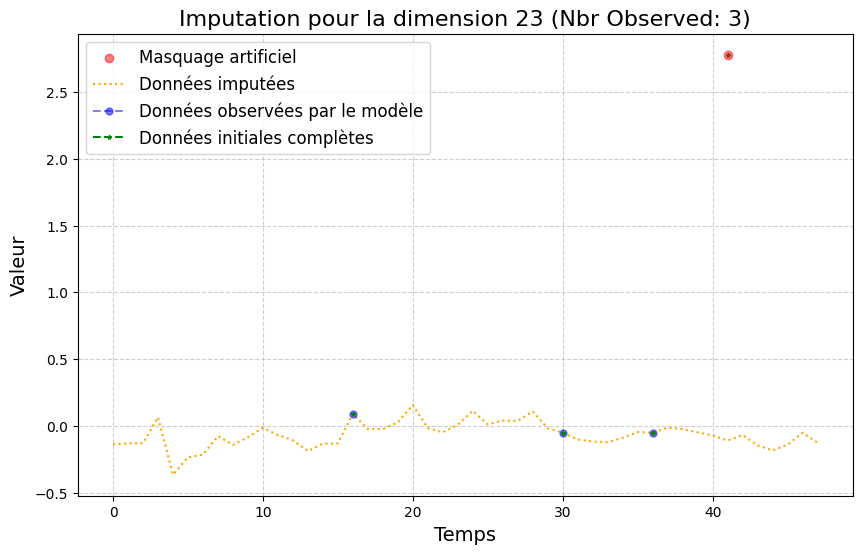

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create directory for saving images
os.makedirs("images_banded", exist_ok=True)

k = 0  # Counter for total images generated

# Iteration over batches of data
for batch_idx, (x_miss_batch, x_full_batch, m_val_artificial_batch, x_imputed_batch) in enumerate(zip(
    x_val_miss_batches, x_val_full_batches, m_val_artificial_batches, x_val_imputed_batches)):

    for sample_idx in range(batch_size - 1):  # Iterate over samples in the batch
        for i in range(x_miss_batch.shape[2]):  # Iterate over dimensions (features)

            # Copy and handle missing data (replace 0 with NaN for better visualization)
            x_miss_batch_copy = x_miss_batch[sample_idx, :, i].copy()
            x_miss_batch_copy[x_miss_batch_copy == 0] = np.nan

            x_full_batch_copy = x_full_batch[sample_idx, :, i].copy()
            x_full_batch_copy[x_full_batch_copy == 0] = np.nan

            # Number of observed points in the data
            nbr_observed = np.sum(~np.isnan(x_miss_batch_copy))

            # Find indices of artificially masked data
            masked_indices = np.where(m_val_artificial_batch[sample_idx, :, i] == 1)[0]

            # Only plot if there are enough observed points and masked indices exist
            if nbr_observed > 2 and masked_indices.size > 0:
                plt.figure(figsize=(10, 6))

                # Plot artificially masked points in red
                plt.scatter(masked_indices, x_full_batch[sample_idx, masked_indices, i], 
                            color="red", label="Masquage artificiel", zorder=5, alpha=0.5)

                # Plot imputed data
                plt.plot(x_imputed_batch[sample_idx, :, i], label="Données imputées", 
                         color="orange", linestyle=":", linewidth=1.5)

                # Plot observed data
                plt.plot(x_miss_batch_copy, label="Données observées par le modèle", 
                         color="blue", linestyle="--", marker="o", markersize=5, alpha=0.5)

                # Plot complete data
                plt.plot(x_full_batch_copy, label="Données initiales complètes", 
                         color="green", linestyle="dashed", marker="*", markersize=3)

                # Add legend
                plt.legend(fontsize=12)

                # Add labels and title
                plt.xlabel("Temps", fontsize=14)
                plt.ylabel("Valeur", fontsize=14)
                plt.title(f"Imputation pour la dimension {i + 1} (Nbr Observed: {nbr_observed})", fontsize=16)

                # Add grid for clarity
                plt.grid(True, linestyle="--", alpha=0.6)

                # Save the figure to file with the specified name format
                file_name = f'images_banded/batch_{batch_idx}_sample_{sample_idx}_dim_{i}.png'
                k += 1
                plt.savefig(file_name)
                plt.close()
